In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import copy
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.auto import tqdm
import gdown

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# model import
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# performance measurement
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

np.random.seed(20221003)
torch.manual_seed(20221003)

In [2]:
# check whether gpu is working
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
!gdown --id '1b5ccXxxbDgQHWKJnTt0mimNbr4BDy_Ck' --output creditcard_sample.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1b5ccXxxbDgQHWKJnTt0mimNbr4BDy_Ck
To: /content/creditcard_sample.csv
100% 35.9M/35.9M [00:00<00:00, 127MB/s]


In [4]:
data = pd.read_csv('/content/creditcard_sample.csv')
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,42432.982130,-0.262096,-0.032374,0.676251,0.162603,-0.278507,0.094066,-0.108712,0.056009,-0.046529,...,-0.030852,-0.109079,-0.037027,0.008982,0.132193,0.026657,0.000606,0.001730,97.962094,0.002230
std,17044.825093,1.859057,1.656854,1.322888,1.349249,1.356376,1.301356,1.210925,1.207528,1.121255,...,0.718882,0.634301,0.632911,0.595255,0.441065,0.494541,0.393700,0.325159,264.624210,0.047171
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,33471.500000,-1.028101,-0.598711,0.176781,-0.711442,-0.898645,-0.647870,-0.600209,-0.137457,-0.698812,...,-0.224509,-0.531305,-0.176416,-0.323712,-0.131794,-0.325102,-0.062534,-0.005355,7.570000,0.000000
50%,44299.000000,-0.260556,0.078315,0.753991,0.192567,-0.314370,-0.157022,-0.069107,0.074130,-0.119105,...,-0.057669,-0.083855,-0.049239,0.064999,0.170104,-0.070347,0.009832,0.023318,26.310000,0.000000
75%,55851.000000,1.153327,0.735736,1.376333,1.032416,0.249733,0.486356,0.414667,0.360506,0.558226,...,0.119190,0.308337,0.081522,0.406281,0.419906,0.300683,0.083025,0.076568,89.000000,0.000000
max,67374.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,22.614889,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


The amount of Null: 0


0    99776
1      223
Name: Class, dtype: int64

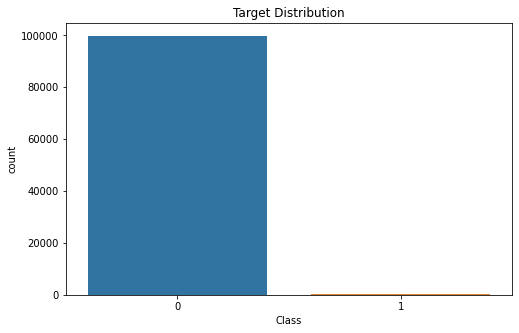

In [6]:
print(f'The amount of Null: {data.isnull().sum().max()}')
plt.figure(figsize=(8,5))
sns.countplot(x='Class', data=data)
plt.title('Target Distribution')
data['Class'].value_counts()


In [7]:
fraud_percent = len(data[data.Class ==1])/len(data)
not_fraud_percent = len(data[data.Class ==0])/len(data)
print(f'The Percent of Fraud: {fraud_percent*100} %')
print(f'The Percent of Not Fraud: {not_fraud_percent*100} %')

The Percent of Fraud: 0.2230022300223002 %
The Percent of Not Fraud: 99.7769977699777 %


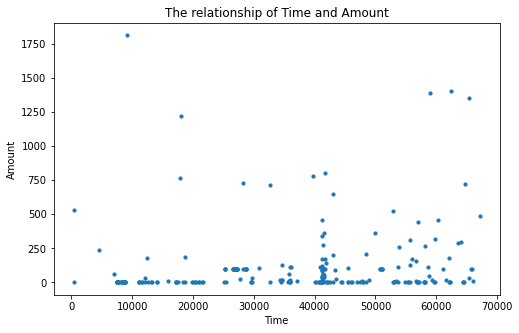

In [8]:
df_fraud = data[data['Class'] == 1]
plt.figure(figsize=(8,5))
plt.scatter(df_fraud['Time'], df_fraud['Amount'], s=10)
plt.title('The relationship of Time and Amount')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

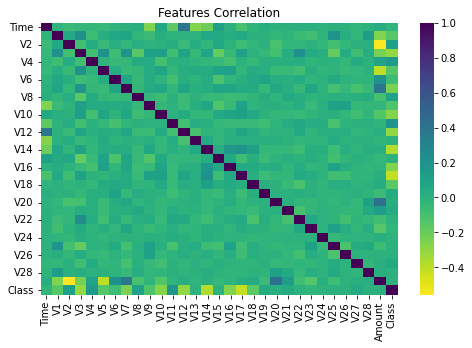

In [9]:
data_corr = data.corr()
plt.figure(figsize=(8,5))
sns.heatmap(data_corr, cmap='viridis_r')
plt.title('Features Correlation')
plt.show()

In [10]:
def measurement(y, prediction):
    cm = confusion_matrix(y, prediction)
    plt.figure(figsize = (8,5))
    sns.heatmap(cm, square=True, annot=True, cbar=False)
    plt.xlabel('Prediction')
    plt.ylabel('True value')
    plt.show()

    report = classification_report(y_true=y, y_pred=prediction)
    print(report)

    # ROC
    fpr, tpr, thresholds = roc_curve(y, prediction, pos_label=1)
    auc_roc = auc(fpr, tpr)
    print(f'auc_roc: {auc_roc}')

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
    plt.legend(loc = 'lower right')
    # plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # RPC
    precision, recall, _  = precision_recall_curve(y, prediction)
    auc_prc = auc(precision, recall)
    print(f'auc_prc: {auc_prc}')

    plt.title('Precision Recall Characteristic')
    plt.plot(precision, recall, 'b', label = 'AUC = %0.2f' % auc_prc)
    plt.legend(loc = 'lower right')
    # plt.plot([1, 0], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()


    

In [11]:
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time'] = scaler.fit_transform(data['Time'].values.reshape(-1,1))

## Part 1

### Training derectly without undersample

In [12]:
# X_data = data.drop('Class', axis=1)
# y_data = data['Class']

X_data = data.iloc[:, 0:-1]
y_data = data.iloc[:, -1]
X_train, X_test, y_train, y_test= train_test_split(X_data,y_data, test_size=0.2, random_state=25)

In [13]:
print("\n--Training data samples--")
print(X_train.shape)


--Training data samples--
(79999, 30)


#### Logistic regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


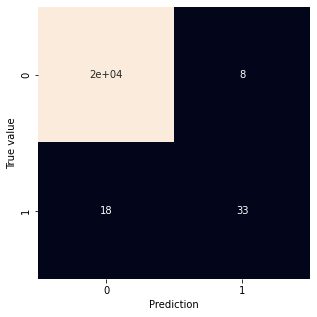

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19949
           1       0.80      0.65      0.72        51

    accuracy                           1.00     20000
   macro avg       0.90      0.82      0.86     20000
weighted avg       1.00      1.00      1.00     20000

auc_roc: 0.823328900460881


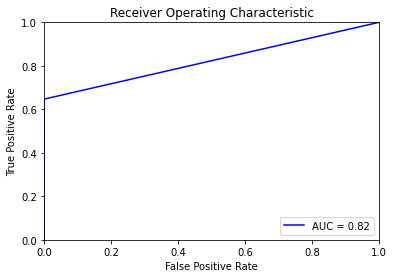

auc_prc: 0.7238684361549498


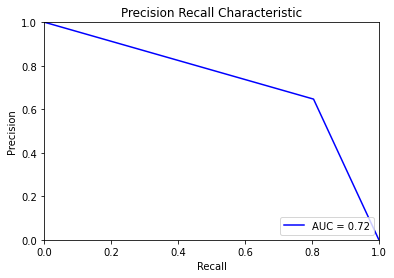

In [14]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
lr_prediction = lr_classifier.predict(X_test)
measurement(y_test, lr_prediction)

#### Support Vector Machine

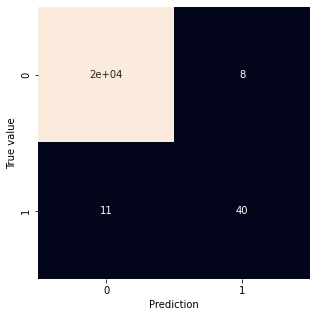

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19949
           1       0.83      0.78      0.81        51

    accuracy                           1.00     20000
   macro avg       0.92      0.89      0.90     20000
weighted avg       1.00      1.00      1.00     20000

auc_roc: 0.8919563514412732


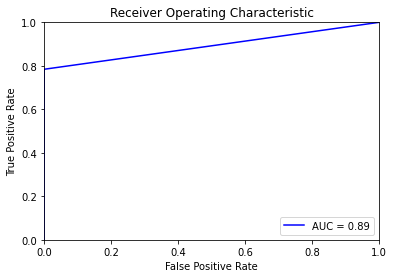

auc_prc: 0.8065485294117646


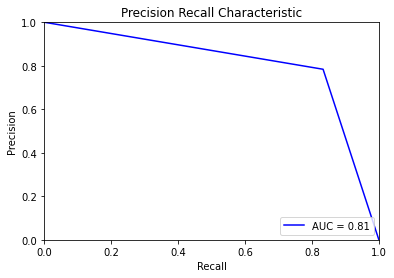

In [15]:
SVC_classifier = SVC(kernel='linear')
SVC_classifier.fit(X_train, y_train)
svm_prediction = SVC_classifier.predict(X_test)
measurement(y_test, svm_prediction)

#### Random Forest

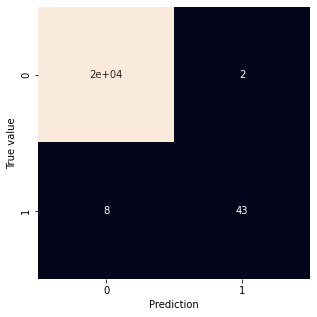

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19949
           1       0.96      0.84      0.90        51

    accuracy                           1.00     20000
   macro avg       0.98      0.92      0.95     20000
weighted avg       1.00      1.00      1.00     20000

auc_roc: 0.9215184996250243


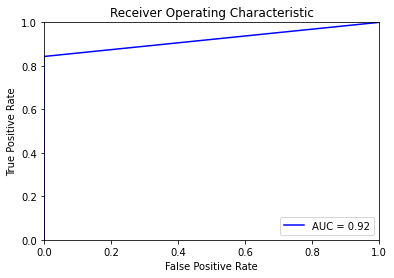

auc_prc: 0.8969964052287582


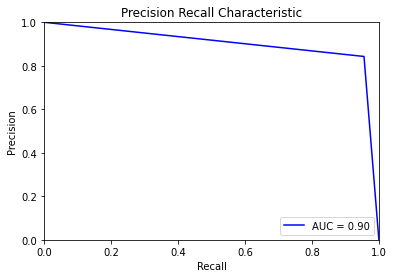

In [16]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_prediction = rf_classifier.predict(X_test)
measurement(y_test, rf_prediction)

## Part2

### Undersample

In [17]:
number_fraud = len(data[data.Class==1])
fraud_indices = np.array(data[data.Class==1].index)
normal_indices = np.array(data[data.Class==0].index)

random_normal_indices = np.random.choice(normal_indices, number_fraud, replace = False)
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = data.iloc[under_sample_indices,:]
X_under_sample_data = under_sample_data.drop('Class', axis=1)
y_under_sample_data = under_sample_data['Class']


### Splitting training and testing data.

In [18]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_under_sample_data,y_under_sample_data, test_size=0.2, random_state=25)

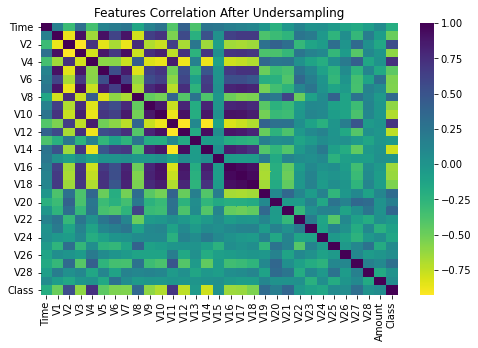

In [19]:
under_sample_data_corr = under_sample_data.corr()
plt.figure(figsize=(8,5))
sns.heatmap(under_sample_data_corr , cmap='viridis_r')
plt.title('Features Correlation After Undersampling')
plt.show()

#### Logistic regression

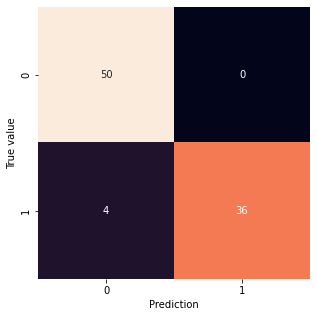

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        50
           1       1.00      0.90      0.95        40

    accuracy                           0.96        90
   macro avg       0.96      0.95      0.95        90
weighted avg       0.96      0.96      0.96        90

auc_roc: 0.95


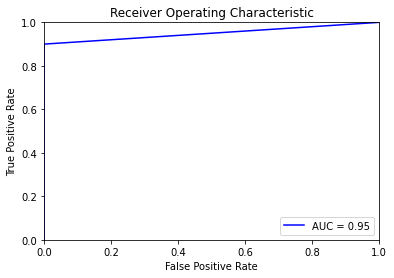

auc_prc: 0.5277777777777778


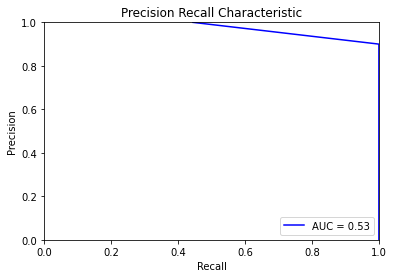

In [20]:
lr_classifier_undersample = LogisticRegression()
lr_classifier_undersample.fit(X_train_undersample, y_train_undersample)
lr_prediction_undersample = lr_classifier_undersample.predict(X_test_undersample)
measurement(y_test_undersample, lr_prediction_undersample)

#### Support Vector Machine

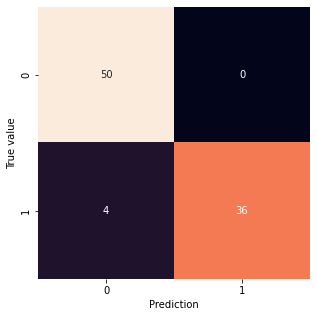

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        50
           1       1.00      0.90      0.95        40

    accuracy                           0.96        90
   macro avg       0.96      0.95      0.95        90
weighted avg       0.96      0.96      0.96        90

auc_roc: 0.95


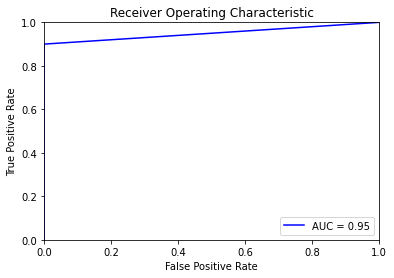

auc_prc: 0.5277777777777778


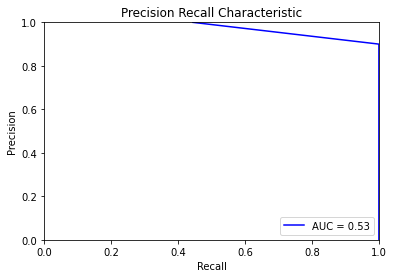

In [21]:
SVC_classifier_undersample = SVC(kernel='linear')
SVC_classifier_undersample.fit(X_train_undersample, y_train_undersample)
svm_prediction_undersample = SVC_classifier_undersample.predict(X_test_undersample)
measurement(y_test_undersample, svm_prediction_undersample)


#### Random Forest

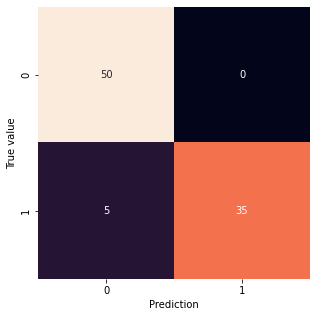

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.88      0.93        40

    accuracy                           0.94        90
   macro avg       0.95      0.94      0.94        90
weighted avg       0.95      0.94      0.94        90

auc_roc: 0.9375


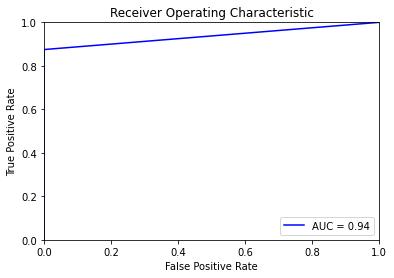

auc_prc: 0.5208333333333334


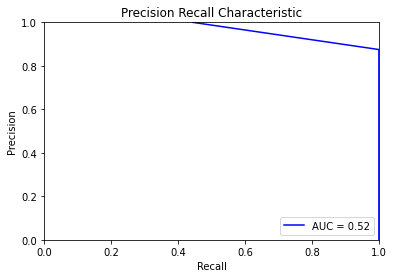

In [22]:
rf_classifier_undersample = RandomForestClassifier()
rf_classifier_undersample.fit(X_train_undersample, y_train_undersample)
rf_prediction_undersample = rf_classifier_undersample.predict(X_test_undersample)
measurement(y_test_undersample, rf_prediction_undersample)

### Deep Neural Network (DNN)

In [23]:
class FraudNet(nn.Module):
    def __init__(self, input_size=30, output_size=1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))

        return x

model = FraudNet()
model = model.to(device)


In [24]:

# Part 1
# X_train_np = X_train.to_numpy()
# X_test_np = X_test.to_numpy()

# X_tensor =  torch.from_numpy(X_train_np).float()
# y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
# X_test_tensor =  torch.from_numpy(X_test_np).float()
# y_test_tensor =  torch.from_numpy(y_test.values.ravel()).float()


# Part 2
X_train_np = X_train_undersample.to_numpy()
X_test_np = X_test_undersample.to_numpy()

X_tensor =  torch.from_numpy(X_train_np).float()
y_tensor =  torch.from_numpy(y_train_undersample.values.ravel()).float()
X_test_tensor =  torch.from_numpy(X_test_np).float()
y_test_tensor =  torch.from_numpy(y_test_undersample.values.ravel()).float()


In [25]:
#Define a batch size
bs = 64
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(X_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)


#For the validation/test dataset
y_test_tensor = y_test_tensor.unsqueeze(1)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [26]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
epochs = 500



In [27]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
best_acc = 0

In [30]:
# model.train()
for epoch in range(epochs):
    acc_train = 0
    running_corrects_train = 0
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        y_pred = model(xb)            # Forward Propagation
        y_pred_tar = torch.round(y_pred)
        running_corrects_train += torch.sum(y_pred_tar  == yb.data)
        loss = loss_func(y_pred, yb)  # Loss Computation
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
        scheduler.step()
    print(f'Training Loss in iteration {epoch} is: {loss.item()}')
    acc_train = running_corrects_train.double() / len(train_dl.dataset)
    train_acc.append(acc_train.item())
    # print(acc_train)
    train_loss.append(loss.item())

    with torch.no_grad():
        acc_test = 0
        running_corrects = 0
        for xb_test, yb_test in test_loader:
            xb_test, yb_test = xb_test.to(device), yb_test.to(device)
            stat = {
                'epoch': epochs,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            y_test_pred = model(xb_test)
            
            loss_ = loss_func(y_test_pred, yb_test)  # Loss Computation
            # y_pred_tag_copy = y_pred_tag.cpu()
            y_pred_tag = torch.round(y_test_pred)
            running_corrects += torch.sum(y_pred_tag  == yb_test.data)
            
            # y_pred_list.append(y_pred_tag_copy.detach().numpy())
        test_loss.append(loss_.item())
        acc_test = running_corrects.double() / len(test_loader.dataset)
        test_acc.append(acc_test.item())

        if acc_test > best_acc:
            torch.save(stat, '/content/best-model-parameters.pt')
            
        print(f'Testing Loss in iteration {epoch} is: {loss_.item()}')

# print(f'Last iteration loss value: {loss.item()}')

Training Loss in iteration 0 is: 0.5501917600631714
Testing Loss in iteration 0 is: 0.5751540660858154
Training Loss in iteration 1 is: 0.5477167963981628
Testing Loss in iteration 1 is: 0.5330407023429871
Training Loss in iteration 2 is: 0.48806795477867126
Testing Loss in iteration 2 is: 0.5101766586303711
Training Loss in iteration 3 is: 0.44459035992622375
Testing Loss in iteration 3 is: 0.47071731090545654
Training Loss in iteration 4 is: 0.4303782880306244
Testing Loss in iteration 4 is: 0.46022918820381165
Training Loss in iteration 5 is: 0.4167819619178772
Testing Loss in iteration 5 is: 0.4412515163421631
Training Loss in iteration 6 is: 0.3987310826778412
Testing Loss in iteration 6 is: 0.41890233755111694
Training Loss in iteration 7 is: 0.3842256963253021
Testing Loss in iteration 7 is: 0.41127392649650574
Training Loss in iteration 8 is: 0.36967766284942627
Testing Loss in iteration 8 is: 0.39423251152038574
Training Loss in iteration 9 is: 0.3676353991031647
Testing Loss 

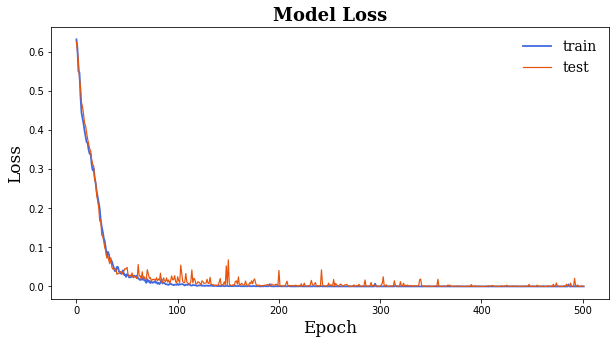

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10, 5),)
plt.plot(train_loss, label='train', color='royalblue', linewidth=1.8)
plt.plot(test_loss, label='test', color='#e6550d', linewidth=1.2)
plt.title('Model Loss',fontsize=18, fontweight='bold', fontfamily='serif')
plt.ylabel('Loss', fontsize=17,  fontfamily='serif')
plt.xlabel('Epoch', fontsize=17,  fontfamily='serif')
font = font_manager.FontProperties(family='serif', size=14)
plt.legend(frameon=False, prop=font)

plt.show()

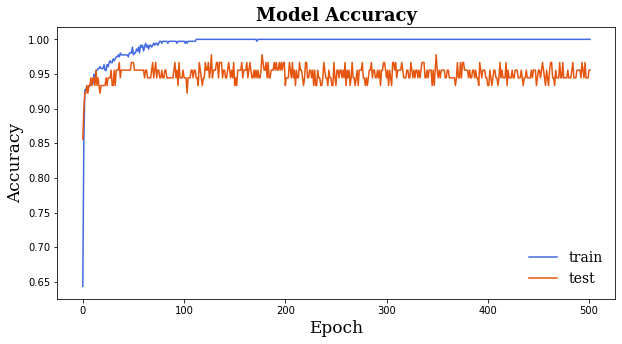

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10, 5),)
plt.plot(train_acc, label='train', color='royalblue', linewidth=1.5)
plt.plot(test_acc, label='test', color='#e6550d', linewidth=1.5)
plt.title('Model Accuracy',fontsize=18, fontweight='bold', fontfamily='serif')
plt.ylabel('Accuracy', fontsize=17,  fontfamily='serif')
plt.xlabel('Epoch', fontsize=17,  fontfamily='serif')
font = font_manager.FontProperties(family='serif', size=14)
plt.legend(frameon=False, prop=font)

plt.show()

In [34]:
import itertools
test_loss = []
y_pred_list = []
model.eval()

model.load_state_dict(torch.load('/content/best-model-parameters.pt')['state_dict'])
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test, yb_test in test_loader:
        xb_test, yb_test = xb_test.to(device), yb_test.to(device)
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        # test_loss = loss_func(y_pred_tag.squeeze(), yb_test)  # Loss Computation
        # test_loss.append(test_loss.item())
        y_pred_tag_copy = y_pred_tag.cpu()
        y_pred_list.append(y_pred_tag_copy.detach().numpy())
#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
y_test_pred = list(itertools.chain.from_iterable(y_pred_list))

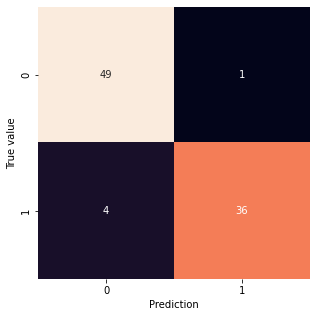

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        50
           1       0.97      0.90      0.94        40

    accuracy                           0.94        90
   macro avg       0.95      0.94      0.94        90
weighted avg       0.95      0.94      0.94        90

auc_roc: 0.94


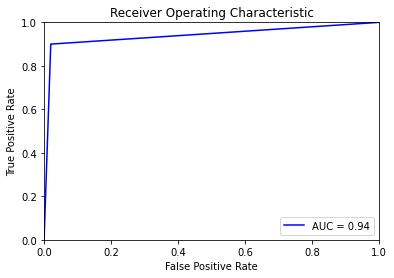

auc_prc: 0.5142642642642643


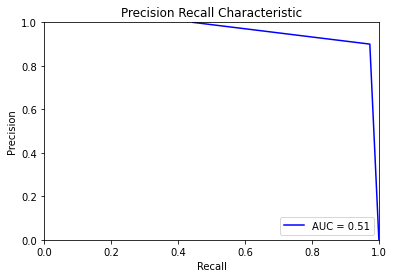

In [35]:
y_true_test = y_test_undersample.values.ravel()
# y_true_test = y_test.values.ravel()
measurement(y_true_test, y_test_pred)